In [ ]:
# Install requirements
%pip install -U setuptools pip
%pip install -r requirements.txt

In [ ]:
# Download MNIST data
!mkdir data
!curl "https://python-course.eu/data/mnist/mnist_train.csv" -o "./data/mnist_train.csv"
!curl "https://python-course.eu/data/mnist/mnist_test.csv" -o "./data/mnist_test.csv"

In [2]:
import csv
import numpy as np

# Read csv files

with open("data/mnist_train.csv") as f:
    reader = csv.reader(f)
    train = np.array(list(reader)).astype("int")

np.random.seed(0)
np.random.shuffle(train)

print(f"Train data shape: {train.shape}")


with open("data/mnist_test.csv") as f:
    reader = csv.reader(f)
    test = np.array(list(reader)).astype("int")

print(f"Test data shape: {test.shape}")

Train data shape: (60000, 785)
Test data shape: (10000, 785)


In [3]:
# Extract labels (1st column) (batch_size,)
train_labels = train[:, 0]
test_labels = test[:, 0]

# Extract features (2nd - last columns)
# Flattened 28x28 grayscale image into 1D array with 784 columns (batch_size, features)
train_features = train[:, 1:]
test_features = test[:, 1:]

# Normalize features (set all values to be between 0.0 - 1.0)
train_features = train_features / 255
test_features = test_features / 255

# One-hot encode labels (10 classes: 0 - 9) (batch_size, classes)
train_labels = np.eye(10)[train_labels]
test_labels = np.eye(10)[test_labels]

print(test_labels)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [20]:
import importlib, os
import numpy as np
import nn, layer, loss

# Set random seed (for reproducibility)
np.random.seed(0)

# Reload modules
for module in (nn, layer, loss):
    importlib.reload(module)

# Folder to save models
folder = "models"

# No. of models
ensemble_size = 10
models = []

# Train neural networks
for x in range(ensemble_size):
    # Fully connected neural network
    layers = [
        layer.LinearLayer(784, 200),
        layer.BatchNorm1DLayer(200),
        layer.ReLULayer(),
        layer.DropoutLayer(0.1),

        layer.LinearLayer(200, 100),
        layer.BatchNorm1DLayer(100),
        layer.ReLULayer(),
        layer.DropoutLayer(0.1),

        layer.LinearLayer(100, 10),
        layer.SoftmaxLayer(),
    ]

    if os.path.exists(f"{folder}/model_{x}.pkl"):
        models.append(nn.load_model(f"{folder}/model_{x}.pkl"))
        print(f"Loaded model {x} from file")
    else:
        models.append(
            nn.NeuralNetwork(
                layers,
                input_size=784,
                output_size=10,
                loss_fn=loss.CrossEntropy(),
                norm="l2",
                norm_alpha=1e-5,
            )
        )

        # Training loop
        models[x].train(
            train_features,
            train_labels,
            lr=0.2,
            epochs=128,
            batch_size=1000,
            x_test=test_features[:1000,],
            y_test=test_labels[:1000,],
            lr_decay=0.99,
        )  # x_test and x_test are only used to calculate accuracy

        # Create folder
        if not os.path.exists(folder):
            os.mkdir(folder)

        # Save models
        models[x].save(f"{folder}/model_{x}.pkl")
        print(f"Saved model {x} to file")

Loaded model 0 from file
Loaded model 1 from file
Loaded model 2 from file
Loaded model 3 from file
Loaded model 4 from file
Loaded model 5 from file
Loaded model 6 from file
Loaded model 7 from file
Loaded model 8 from file
Loaded model 9 from file


In [21]:
# Ensemble scores
print(
    "Soft voting (mean): {:.2f}%".format(
        nn.score_ensemble_mean(models, test_features, test_labels) * 100
    )
)
print(
    "Hard_voting (mode): {:.2f}%".format(
        nn.score_ensemble_mode(models, test_features, test_labels) * 100
    )
)

Soft voting (mean): 96.93%
Hard_voting (mode): 96.81%


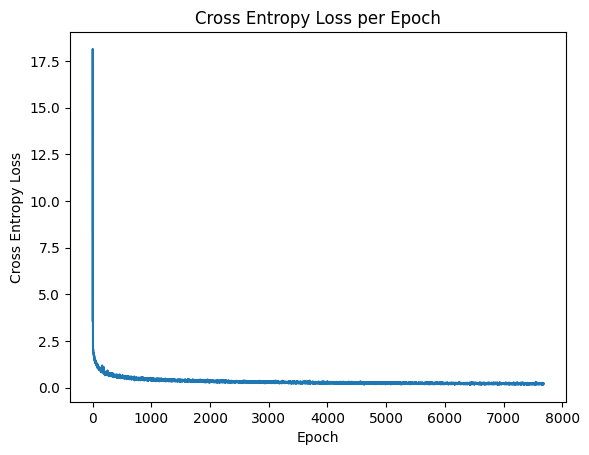

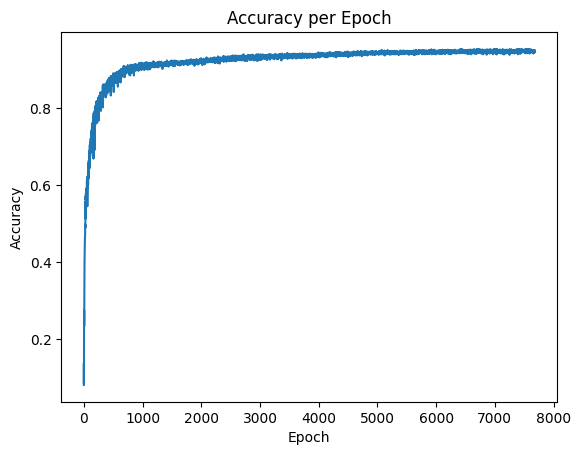

Predicted: 7
Actual: 7


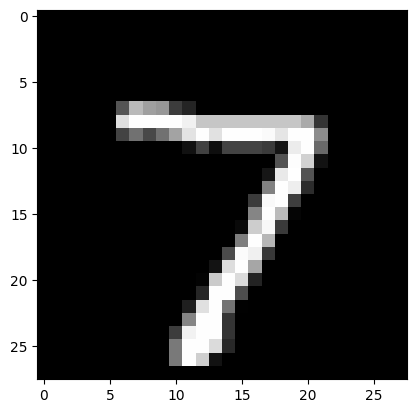

In [22]:
%matplotlib inline

# Single model loss and accuracy
models[0].plot_loss()
models[0].plot_acc()

# Test prediction from an index
models[0].test_pred(0, test_features, test_labels)